In [445]:
import numpy as np
import scipy.linalg as la
import scipy
import random
import networkx as nx
import copy

In [548]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [549]:
def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6., 6.])
    elif(n == 2):
        a = np.array([[-6., 15.], [-6., -15.], [8., 0.]])
    elif(n == 3):
        a = np.array([[-6., 15.,-10.], [-6., -15.,-10.], [8., 0., -10.], [0., 0., 10.]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)
    
    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        #print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [550]:
#The objective barrier function
def phi(a, x, b):
    return (0.5 * np.dot((A_X(a, x) - b).transpose(), A_X(a, x) - b))

#The gradient of the objective barrier function in 8b
def dphi(a, x, b, npoints, n):
    y = A_X(a, x) - b  
    T = npoints + n
    gradf = np.zeros((T, T))
    for ind, A in enumerate(a):
        gradf = gradf + y[ind] * A
    return gradf

#The updated gradient of the object barrier function in 8c
def ddphi(a, x, b, npoints, n):
    y = A_X(a, x) - b
    
    T = npoints + n
    gradf = np.zeros((T, T))
    for ind, A in enumerate(a):
        gradf = gradf + y[ind] * A
    return np.matmul(np.matmul(x, gradf), x)

#Performs the operation AX as enumerated in the assignment
def A_X(a, x):
    element_wise = [np.multiply(A, x) for A in a]
    return np.array([A.sum() for A in element_wise])

In [551]:
#Performs steepest descent
def steepest_descent(op, dop, a, xin, b, niter, npoints, n):
    x = np.copy(xin)
    for i in range(0, niter):
#         print "INSIDE"
        grad = dop(a, x, b, npoints, n)
        alpha = 1.
#         print "a: ", a
#         print "x: ", x
#         print "b: ", b
        
        #Here, we perform the backtracking line search
        #but we also want the smallest eigenvalue of x^(k+1)
        #to be at least half of the smallest eigenvalue of
        #x^k
        e_val_new, e_vec = np.linalg.eig(x - alpha*grad)
        e_val_old, t = np.linalg.eig(x)
        ratio = np.amin(e_val_new)/np.amin(e_val_old)
        
        #Perform backtracking
        while((phi(a,x - alpha*grad, b) > phi(a, x, b)) \
              or ratio < 0.5):
            alpha *= 0.8
            e_val_new, t = np.linalg.eig(x - alpha*grad)
            e_val_old, t = np.linalg.eig(x)
            ratio = np.amin(e_val_new)/np.amin(e_val_old)
            
        x -= alpha * grad
        e_val_new[e_val_new < 0] = 0
        x = np.dot(np.dot(e_vec.transpose(), np.diag(e_val_new)), e_vec)
        x = np.real(x)
    return x

#Performs steepest descent
def steepest_descent_ldl(op, dop, a, xin, b, niter, npoints, n):
    x = np.copy(xin)
    for i in range(0, niter):
        grad = dop(a, x, b, npoints, n)
        alpha = 1.
        
        #Here, we perform the backtracking line search
        #but we also want the smallest eigenvalue of x^(k+1)
        #to be at least half of the smallest eigenvalue of
        #x^k
        
        #Perform backtracking
        while(phi(a,x - alpha*grad, b) > phi(a, x, b)):
            if(alpha < 1e-9):
                break
            alpha *= 0.8
        x -= alpha * grad

        (P, L, U) = la.lu(x)
        D = np.diag(np.diag(U))
        U /= np.diag(U)[:, None]
        d = copy.copy(np.diag(D))
        d = np.array([-elem if elem < 0 else elem for elem in d])
        D = np.diag(d)
        x = P.dot(L.dot(D).dot(L.transpose()))
        
    return x

#Performs steepest descent
def steepest_descent_largest_evals(op, dop, a, xin, b, niter, npoints, n):
    x = np.copy(xin)
    for i in range(0, niter):
        grad = dop(a, x, b, npoints, n)
        alpha = 1.
        
        #Here, we perform the backtracking line search
        #but we also want the smallest eigenvalue of x^(k+1)
        #to be at least half of the smallest eigenvalue of
        #x^k
        
        #Perform backtracking
        while(phi(a,x - alpha*grad, b) > phi(a, x, b)):
            if(alpha < 1e-9):
                break
            alpha *= 0.8
        x -= alpha * grad
        
        temp = np.zeros((npoints + n, npoints + n))
        evals = scipy.linalg.eigh(x, eigvals_only = True, eigvals = (npoints + n - 6, npoints + n - 1))
        t, evecs = scipy.linalg.eigh(x)
        evecs = evecs[:, -6:]
        
        evals[evals < 0] = 0
        
        for i, e_val in enumerate(evals):
            temp += e_val * np.outer(evecs[:,i], evecs[:,i])
        
        x = temp
        
    return x

In [562]:
n = 2
npoints = 30

(a, p, adjacency) = generate_inside_hull(n, npoints)

# Compute the Euclidian distances to the anchor points
adjSize = len(p) + len(a)
asize = len(a)
d = []

for i in range(adjSize):
    for j in range(adjSize):
        if(j > i and adjacency[i][j] > 0 and i < asize):
            d.append((adjacency[i][j], j - asize, i, True))
        elif(j > i and adjacency[i][j] > 0):
            d.append((adjacency[i][j], i - asize, j - asize, False))

T = n + npoints

eyeConstraint = []
anchorConstraints = []
pointConstraints = []

for i in range(n):
    temp = np.zeros((T,T))
    temp[i][i] = 1
    eyeConstraint.append((temp, 1))
    
temp = np.zeros((T,T))
for i in range(n):
    for j in range(n):
        temp[i][j] = 1
eyeConstraint.append((temp, n))

for (distance, i, j, truth) in d:
    if truth:
        temp = np.zeros(npoints)
        temp[i] = -1.
        anchorConstraints.append((np.outer(np.append(a[j], temp), np.append(a[j], temp)), distance ** 2))
    else:
        tempi = np.zeros(npoints)
        tempj = np.zeros(npoints)
        tempi[i] = 1.
        tempj[j] = 1.
        temp = tempi - tempj
        corner = np.zeros(n)
        temp = np.append(corner, temp)
        pointConstraints.append((np.outer(temp,temp), distance ** 2))

matConstraints = eyeConstraint + anchorConstraints + pointConstraints

A = [mat[0] for mat in matConstraints]
b = [mat[1] for mat in matConstraints]

X = np.random.rand(T,T)
X = np.dot(X, X.transpose())

for i in range(n):
    for j in range(n):
        if(i == j):
            X[i][j] = 1
        else:
            X[i][j] = 0

# for i in range(2):
import time

print "Steepest Descent"
start = time.time()
soln = steepest_descent(phi, dphi, A, X, b, 200, npoints, n)
Solution = soln[0:n, n:n + npoints].transpose()
end = time.time()
print "Time to compute in seconds: ", end - start
print "Average MSE: ", np.linalg.norm(p - Solution)

print "LDL Factorization"
start = time.time()
soln = steepest_descent_ldl(phi, ddphi, A, X, b, 200, npoints, n)
Solution = soln[0:n, n:n + npoints].transpose()
end = time.time()
print("Time to compute: ", end - start)
print "Average MSE: ", np.linalg.norm(p - Solution)

print "6 Largest Eigenvalues and vectors"
start = time.time()
soln = steepest_descent_largest_evals(phi, ddphi, A, X, b, 200, npoints, n)
Solution = soln[0:n, n:n + npoints].transpose()
end = time.time()
print("Time to compute: ", end - start)
print "Average MSE: ", np.linalg.norm(p - Solution)

Steepest Descent
Time to compute in seconds:  36.5392827988
Average MSE:  19.6515348108
LDL Factorization
('Time to compute: ', 28.499589920043945)
Average MSE:  25.1126745891
6 Largest Eigenvalues and vectors
('Time to compute: ', 16.455264806747437)
Average MSE:  19.6638932138


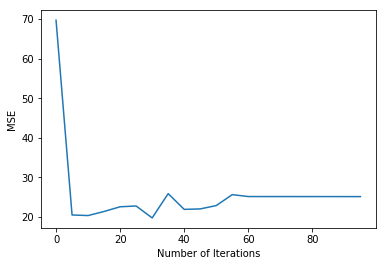

In [569]:
iterList = [i for i in range(0, 100, 5)]
MSEGraph = []
for it in iterList:
    soln = steepest_descent_ldl(phi, ddphi, A, X, b, it, npoints, n)
    Solution = soln[0:n, n:n + npoints].transpose()
    MSEGraph.append(np.linalg.norm(p - Solution))

plt.plot(iterList, MSEGraph)
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.show()

Populating the interactive namespace from numpy and matplotlib


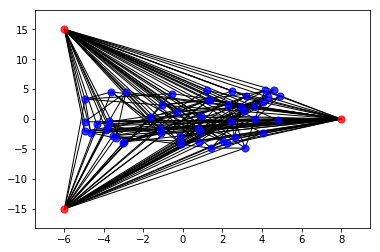

In [559]:
%pylab inline --no-import-all
if(n == 2):
    G=nx.Graph()

    for i in range(n+1):
        G.add_node(i,pos=a[i])

    for i in range(npoints):
        G.add_node(n+1+i,pos=p[i])

    pos=nx.get_node_attributes(G,'pos')

    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1)],
                           node_color='r',
                           node_size=50,
                           alpha=0.8)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1,npoints+n+1)],
                           node_color='b',
                           node_size=50,
                           alpha=0.8)
    for i in range(npoints+n+1):
        for j in range(n+1,npoints+n+1):
            if(adjacency[j,i] > 0.):
                G.add_edge(i,j)

    nx.draw_networkx_edges(G,pos)
    plt.draw()  # pyplot draw()